# La régression logistique

La présentation précédante montrait comment la régression linéaire pouvait être considérée comme une première application d'apprentissage automatique. Cette présentation va maintenant présenter la [régression logistique](https://fr.wikipedia.org/wiki/R%C3%A9gression_logistique) qui est une autre forme de régression, mais avec l'objectif de classer.

Le problème qui est posé ici n'est plus de trouver une équation qui permettrait de représenter un nuage de point, mais de caractégoriser une population par rapport à des catégories en nombre discret (ou ce peut être simplement un vrai/faux).

Cette méthode tire son nom de la fonction [logit](https://fr.wikipedia.org/wiki/Logit) qui est utilisé dans cette méthode. L'expression de cette fonction est la suivante.

$$\text{logit}(p) = ln\left(\frac{p}{1-p}\right)$$

où $p$ est défini sur $]0, 1[$. La base du logarithme n'a pas d'importance, tant qu'elle est supérieure à 1. On peut choisir le logarithme népérien où à base 10.

Voici son graphe en utilisant cette fois l'extension [plotly](https://plotly.com/python/).

In [43]:
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

# mon style personnalisé pour les graphiques
fond_gris = {
  'layout': go.Layout(
            title={'font_size':24, 'font_color':'black'},
            margin={'t': 60, 'b': 10, 'l': 20, 'r': 20},
            paper_bgcolor='gray',
            plot_bgcolor='lightgray'
  )
}
# plus d'info sur les personnalisations graphiques sur :
# https://plotly.com/python/templates/

# déclaration d'une série de points
p = np.arange(0.01, 1, 0.01)

# création de notre figure
fig = go.Figure(data=go.Scatter(x=p, y=np.log(p/(1-p))))

# mise à jour d'un titre et de la personnalisation
fig.update_layout(title='la fonction logit',
                  template=fond_gris)
fig.show()

Outre ces asymptote et sa valeur nulle en $\frac{1}{2}$, cette fonction a quelques propriétés intéressantes.

Sa dérivée :

$$ \frac{d}{dx}\text{logit}(x) = \frac{1}{x} - \frac{1}{x-1} $$

et son intégrale :

$$ \int_0^x \text{logit}(t) dt = x \cdot \text{logit}(x) + \ln (1-x) $$

La fonction [logit](https://fr.wikipedia.org/wiki/Logit) a comme fonction réciproque de fonction [Sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)).

$$\sigma(x) = \frac{1}{1 + e^{-x}} $$

In [44]:
x = np.arange(-6, 6, 0.1)

fig = go.Figure(data=go.Scatter(x=x, y=1/(1+np.exp(-x))))
fig.update_layout(title='la fonction Sigmoïde',
                  template=fond_gris)

fig.show()

On généralise cette fonction [Sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)) en introduisant un paramètre $\theta$.

$$\sigma_\theta(x) = \frac{1}{1+e^{-\theta x}}$$

Cette fonction  possède certaines propriétés intéressantes comme pour sa dérivée.

$$\frac{d\sigma_\theta(x)}{dx} = \frac{\theta e^{-\theta x}}{\left(1+e^{-\theta x}\right)^2}$$

Si on pose $y = \sigma_\theta(x)$, on peut ré-écrire cette dérivée ainsi.

$$\frac{dy}{dx} = \theta\cdot y \cdot (1 - y)$$

Avec donc $y$ variant entre 0 et 1. 

Avec le cas $\theta = 1$, la dérivée de cette fonction Sigmoïde en est la probabilité d'arriver à cette valeur et pas au dessus.

Cette expression sera ensuite réutilisée plus bas pour la méthode utilisant la descente du gradient.

L'intérêt de cette fonction est qu'à partir d'une population distribuée sur l'axe x et se répartissant déjà à peu près sur deux groupes (les petites valeurs et les grandes valeurs), on peut définir un seuil placé judicieument "au milieu", qui départagera des résultats entre 0 et 1.

![départage par sigmoïde](./img/departage_sigmoide.png)

La fonction Sigmoïde va permettre de renforcer la clarté de réponse oui ou non à la question posée.

# Construction d'un échantillon aléatoire séparable

*(cette partie est reprise d'une partie [d'article sur le régression venant de l'université de Montpelier](https://www.univ-montp3.fr/miap/ens/miashs/master/ues/test_maximilien/htmls/3_classification/1_logistic_regression.html) qui peut d'ailleurs aussi se télécharger comme un fichier `ipynb`)*

L'objectif est de construire un ensemble de points $(x_i, y_i)_i$ répartis aléatoirement dans le plan, mais qui pourront être séparés clairement par une droite. Plus tard, ce sera cette droite que nous chercherons à trouver par régression.

Comme dans le cas de la régression linéaire, une troisième dimension fictive définissait une hauteur fictive permettant de définir un minimum visible. Cette troisième dimension fictive va être ré-utilisée ici de manière un peu plus complexe. La suite du texte utilise soit la notation classique $(x,y,z)$ des points de l'espace, soit la notation par indice $(x_0,x_1, x_2)$ parfois plus pratique.


On se donne un vecteur $\beta$ dans $[0, 1]^3$ dont on utilise la projection $\beta'$ de $\beta$ sur $\mathbb{R}^2$ en ne gardant que les deux dernières coordonnées.

$$\beta' = \left[\begin{array}{c}
                   \beta_1 \\ \beta_2
                  \end{array}\right] $$

Si maintenant on se donne un vecteur $\mu \in \mathbb{R}^2$ défini de la manière suivante :

$$ \mu = \left( -\frac{\beta_0}{\left\lVert\beta'\right\rVert^2}\right) \cdot \beta'  $$

En refaisant le produit scalaire entre $\mu = (x_1, x_2)$ et $\beta'$, on trouve :
$$ 
\begin{align}
  & \beta' \bullet \mu + \beta_0 = 0 \\
  & \beta_1  \cdot x_1 + \beta_2\cdot x_2 + \beta_0 = 0 \\
  & \beta_1 \cdot x + \beta_2 \cdot y + \beta_0 = 0 \\
\end{align}
$$

Cette dernière équation nous donne l'équation d'une droite du plan qui va nous servir à séparer un échantillon aléatoire du plan en deux catégories :

$$ \forall x_i \in \cal{P}, \quad
  y_i = \left\{
        \begin{array}{lll}
         1 & \text{si} & \beta_1\cdot x_i + \beta_2 \cdot y_i + \beta_0 > 0 \\
         0 & \text{sinon} &\\
        \end{array} 
  \right.
$$

En récapitulant, les étapes pour la création de cet échantillon aléatoire séparable sont donc les suivantes :
1) se donner un vecteur $\beta = (\beta_0, \beta_1, \beta_2)$
2) se donner un population aléatoire du plan $X = (x,y) \in \mathbb{R}^2$
3) catégoriser ces points en fonction du signe de $(\beta_1\cdot x + \beta_2\cdot y + \beta_0)$

Par construction cette population catégorisée sera séparable par la droite d'équation :

$$ y = -\frac{\beta_1}{\beta2} \cdot x - \frac{\beta_0}{\beta_2}$$ 

Dans le code Python proposé, on choisit $\beta$ aléatoirement. Le code  diffère un peu ici de celui de l'article, Python recommande de passer maintenant  par deux étapes pour générer un nombre aléatoire : 
- d'abord on construit un générateur de nombres aléatoires [numpy.random.default_rng](https://numpy.org/doc/stable/reference/random/generator.html)
- ensuite on applique une loi de distribution à ce générateur, par exemple la [loi Normale](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.standard_normal.html#numpy.random.Generator.standard_normal) ou bien la [distribution aléatoire uniforme appelée usuellement random](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html).

In [2]:
import numpy as np
rng = np.random.default_rng()

# beta = rng.standard_normal(3)  # si on utilise un loi normale
beta = rng.random(3)             # si on utilise la loi aléatoire uniforme
beta


array([0.73137343, 0.64660534, 0.37001323])

La propriété permettant de catégoriser les points du plan est un produit scalaire de deux vecteurs. Ceci se fait directement en Python avec la fonction [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html). La norme d'un vecteur se calcule aussi tout simplement avec [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

Avec les aides de ces extensions, la formule $(\beta' \bullet X + \beta_0)$ s'écrit aussi en une ligne 
en Python et on peut vérifier que si on prend $X=\left( -\frac{\beta_0}{\left\lVert\beta'\right\rVert^2}\right) \cdot \beta'$ , on retrouve bien 0.

In [3]:
mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
print(f"{np.dot(beta[1:3], mu) + beta[0]:.6f}")

0.000000


En Python, nous utiliserons la fonction [numpy.random.RandomState.multivariate_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.multivariate_normal.html#numpy.random.RandomState.multivariate_normal) pour générer la population $(x_i, y_i)_i$ où chacune des dimensions suivra une loi Normale indépendante. 

Pour cela on se donnera des covariances à 0 et des variances à 1 (pour des lois normales standardisées). En Python, on construit une matrice faite de 1 avec la fonction [numpy.ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) qu'on diagonalise avec [numpy.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html).

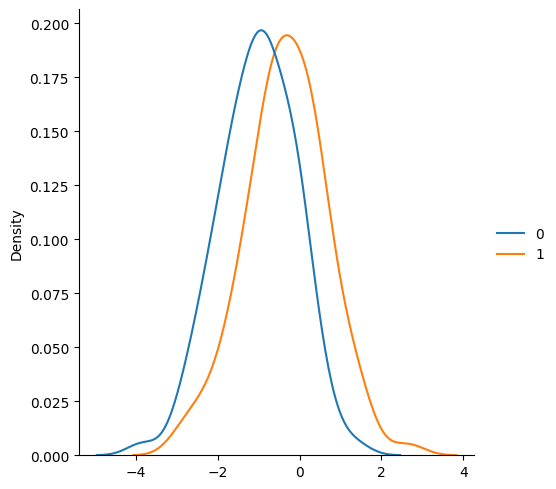

In [4]:
cov = np.diag(np.ones(2))
n = 100 # effectif de la population
x = np.random.default_rng().multivariate_normal(mu,cov,n)
# affichage de la distribution des deux variables aléatoires
import seaborn as sns
sns.displot(x, kind="kde")

Les deux deux familles gardent des moyennes proches, car ces moyennes sont par construction entre -1 et 1.

On construit donc notre échantillon avec la fonction suivante qui utilise la fonction [numpy.insert](https://numpy.org/doc/stable/reference/generated/numpy.insert.html) pour ajouter des échantillons.

In [5]:
def sample_data(n, beta):
    # construction du vecteur servant à séparer
    mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
    # la matrice variances/covariances
    cov  = np.diag(np.ones(2))
    # la génération de la population (x)
    X = np.insert(np.random.default_rng().multivariate_normal(mu,cov,n),0,1,axis=1)
    # détermination de la catégorie du x tiré
    y = (np.dot(X, beta)>0)*1
    return X, y

X, y = sample_data(100, beta)

On affiche maintenant le résultat, la population séparée en deux catégories colorées différement et la droite les séparant. On utilise la fonction [matplotlib.pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) qui représente un nuage de point.


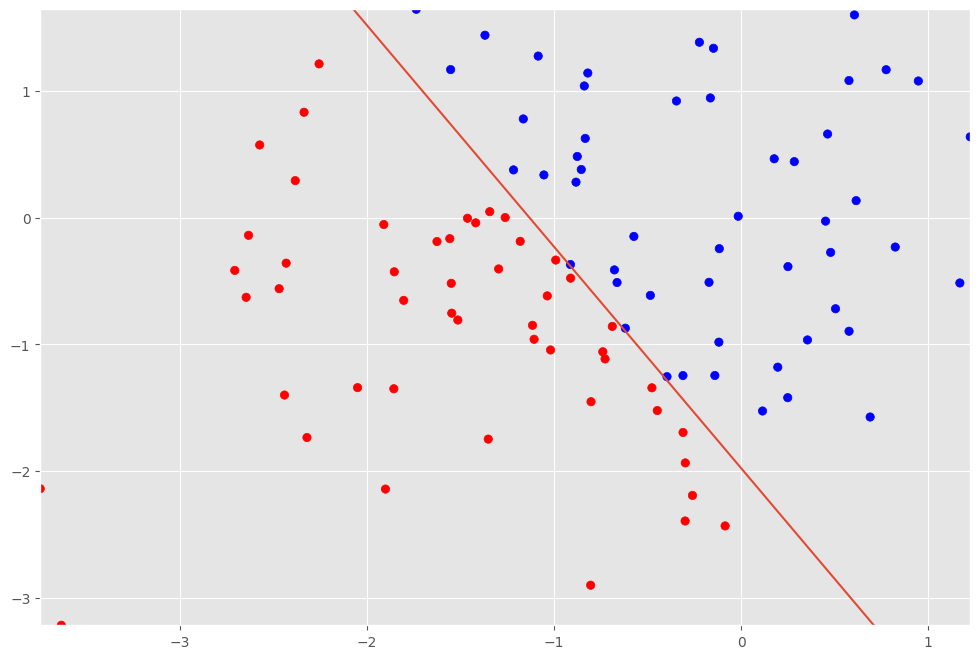

In [6]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

def plot(X, y, beta=None, predictor=None, title=None):
    ymin_ = X[:,2].min()
    ymax_ = X[:,2].max()
    min_ = X[:,1].min()
    max_ = X[:,1].max()
    
    if predictor is not None:
        h = 0.02
        xx, yy = np.meshgrid(np.arange(min_, max_, h), np.arange(ymin_, ymax_, h))
        Z = predictor.predict(np.insert(np.c_[xx.ravel(), yy.ravel()], 0, 1, axis=1))
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z,shading='auto', alpha=0.01)

    # Construction de la liste des couleurs à donner aux points.
    # Ces couleurs sont en fonction de 'y' qui peut être
    # égale à 0 ou 1.
    C=[]
    for i in y:
        if i==0:
            C.append('r')
        else:
            C.append('b')
    # impression du nuage de points
    plt.scatter(X[:,1], X[:,2],c=C)
    
    # impression de la droite de séparation
    if beta is not None:
        x_ = np.linspace(min_, max_, 500)
        y_  = -beta[0]/beta[2] - x_ * beta[1] / beta[2]
        plt.plot(x_, y_)
    
    if title is not None:
        plt.title(title)
    plt.xlim(min_, max_)
    plt.ylim(ymin_, ymax_)
    plt.show()
    
plot(X, y, beta)

On peut relancer le calcul de toutes les cellules et ce graphe va changer : les paramètres $(\beta_0, \beta_1, \beta_2)$ vont changer ainsi que le tirage de la population $(x_i,y_i)_i$.

# Fonction objectif et gradient



Dans cette partie, nous gardons la population de points $X = (x_i,y_i)_i$ que nous avons tirés plus haut l'objectif est de retrouver par régression les coefficients $\beta$ permettant de construire la droite qui les sépare en deux catégories. 

$$ \forall (x_i, y_i) \in \cal{S}, \quad y_i = \left\{ 
         \begin{array}{lll}
         1 & \text{si} & \beta_1 \cdot x_i + \beta_2\cdot y_i + \beta_0 > 0 \\
         0 & \text{sinon} &\\
         \end{array}     
         \right. $$

Il faudra donc retrouver ces paramètres $\beta = (\beta_0,\beta_1,\beta_2)$ à partir de l'observation des points $X =(x_i,y_i)$.

Soit $p_\beta$ la probabilité que cette population $(x_i, y_i)_i$ soit dans la catégorie $1$ et donc $(1-p_\beta)$ la probabilité d'être dans la catégorie $0$. On peut écrire la vraissemblance de la façon suivante.

$$\cal{L}(\cal{S_\beta}) = \prod_{(x,y) \in \cal{S}} p_\beta^{y} \cdot (1-p_\beta)^{1-y}$$

De façon à rendre les calculs qui suivent plus simples, on prend le logarithme négatif de cette vraissemblance.

$$J(\beta) = -\log\left(\cal{L}(\cal{S_\beta})\right) = - \sum_{(x,y) \in \cal{S_\beta}} y\log(p_\beta) + (1-y)\log(1-p_\beta)$$

Maximiser la vraissemblance $\cal{S_\beta}$ est équivalent à minimiser cette fonction $J(\beta)$ en fonction du vecteur $\beta$.

Pour rendre les expressions qui suivent plus simples à lire, on introduit une notation pour cette opération particulière qui a été introduite :

$$\beta \perp X = \beta_1 \cdot x + \beta_2 \cdot y + \beta_0 $$

Sur la population effective, cette expression aura des valeur continues. Pour partager la population entre 0 et 1, cette expression est passée par la fonction Sigmoïde : $\sigma(\beta \perp X)$

On cherchera donc à minimiser la fonction suivante.

$$J(\beta) = -\sum_{(x,y) \in \cal{S}} y\log(\sigma(\beta \perp X)) + (1-y)\log(1 - \sigma(\beta \perp X))$$ 

En utilisant les propriétés de la fonction Sigmoïde vues plus haut, on peut écrire la dérivé partielle en fonction de $\beta_1$.

$$\frac{\partial \sigma(\beta \perp X)}{\partial \beta_1} = x \cdot \sigma(\beta \perp X) \cdot \left(1 - \sigma(\beta \perp X)\right) 
$$

Et donc en prenant la dérivée du logarithme, une partie se simplifie.

$$\frac{\partial \log(\sigma(\beta \perp x))}{\partial \beta_1} = x\cdot(1 - \sigma(\beta \perp X))$$

et pour l'autre membre

$$\frac{\partial \log(1 - \sigma(\beta \perp X))}{\partial \beta_1} = -x \cdot \sigma(\beta \perp X)$$


Ces simplifications permettent (après quelques calculs) de retrouver des expressions assez simples des dérivées partielles :

$$
\begin{align*}
\frac{\partial J(\beta)}{\partial \beta_0} &= \sum_{i=1}^m \sigma(\beta \perp X) - y_i \\
\frac{\partial J(\beta)}{\partial \beta_1} &= \sum_{i=1}^m [ \sigma(\beta \perp X) - y_i ] \cdot x_i \\
\frac{\partial J(\beta)}{\partial \beta_2} &= \sum_{i=1}^m [ \sigma(\beta \perp X) - y_i ] \cdot y_i \\
\end{align*}
$$

Ces dérivées partielles permettront de déterminer le gradient pour d'implementer la recherche des paramètres $(\beta_0,\beta_1,\beta_2)$ qui minimiseront la fonction $J$ avec la même méthode générale que nous avons vue avec la régression linéaire.

La résolution Python qui est proposée utilise de la programmation objet avec une classe `CrossEntropy` qui calcule le minimum de cette fonction $J(\beta)$. La population $X$ que nous avons tirée est en réalité composées de trois coordonnées, mais seules le deux dernières nous intéressent. On les obtients ainsi.

In [7]:
# les deux dernières colonnes, limitées aux 5 premières lignes
X[:,1:][:5]

array([[-0.87631244,  0.48451955],
       [-1.26175178,  0.00239297],
       [-1.11567077, -0.84845333],
       [-0.11677338, -0.24335122],
       [ 0.24910766, -1.41972758]])

In [86]:

v_loss = np.dot(X.T[1:].T*(-beta[0]/(np.linalg.norm(beta[1:3])**2)), beta[1:3])
loss = 0
for v in v_loss:
    loss += v
print(f"{loss:.6f}")
# np.dot(beta[1:3], loss) + beta[0]

74.008548


In [98]:
import logging
logging.basicConfig(level=logging.DEBUG)

def sigmoid(x, beta):
    return (1+np.exp(-np.dot(x, beta)))**(-1)

class CrossEntropy(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.idx = np.array([i for i in range(self.X.shape[0])])
        self._pos = 0
        
    def _format_ndarray(arr):
        arr = np.array(arr) if type(arr) is not np.ndarray else arr
        # return arr.reshape((arr.shape[0], 1)) if len(arr.shape) == 1 else arr
        return arr
    
    def predict(self, X):
    
        ####### Complete this part ######## or die ####################
        y_pred = 0
        ###############################################################

        return y_pred
    
    def val(self, beta):
        beta = CrossEntropy._format_ndarray(beta)

        ####### Complete this part ######## or die ####################
        lloss = np.dot(self.X[:,1:]*(-beta[0]/(np.linalg.norm(beta[1:3])**2)), beta[1:3]) + beta[0]        
        loss = 0
        for v in lloss:
            loss += v 
        return loss
        ###############################################################
    
    def _shuffle(self):
        np.random.shuffle(self.idx)
    
    def grad(self, beta, batch_size=-1):
        batch_size = self.X.shape[0] if batch_size == -1 else batch_size
        idx = self.idx[self._pos:self._pos+batch_size]

        self._pos = (self._pos+batch_size) % self.X.shape[0]
        if self._pos == 0:
            self._shuffle()
            
        X, y = self.X[idx], self.y[idx]
        y = CrossEntropy._format_ndarray(y)

        beta = CrossEntropy._format_ndarray(beta)
        
        ####### Complete this part ######## or die ####################
        loss = self.val(beta)
        logging.debug(f"loss={loss:.2f}")
        logging.debug(f"beta={beta[0]:.2f}")
        sigma = sigmoid(loss, beta[0])
        logging.debug(f"sigma={sigma:.2f}")
        logging.debug(f"y={y}")
        res = sigma * np.array([1,1,1]) - y
        res @= self.X
        return res
        ###############################################################

l = CrossEntropy(X, y)
print(f"La valeur d'écart au beta recherché est {l.val(beta):.2f}")

print(f"Le gradient pour beta est\n, {l.grad(beta)}")

DEBUG:root:loss=90.39
DEBUG:root:beta=0.16
DEBUG:root:sigma=1.00
DEBUG:root:y=[1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1
 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1
 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0]


La valeur d'écart au beta recherché est 90.39


ValueError: operands could not be broadcast together with shapes (3,) (100,) 

# Analyse multifactorielle

Avec une multitude de facteur, on applique cette fonction Sigmoïde aux différentes entrées $X_k=(x_{(k,i)})_i$ avec des coefficients $\theta_k$.

![entrées fonction sigmoïde](./img/TJSLL8DR0K.png)

Chaque $X_1, X_2, X_3, X4$ de ce schéma est en fait une population d'entrées observées $X_1 = (x_{1,i})_{i \in \{1..m\}}$, qui sont donc représentées par un vecteur de $\mathbb{R}^m$. Ces quatres populations (qu'on généralisera par $n$) sont ensuite pondérée par des paramètres $\Theta = (\theta_k)_{k \in \{1..n\}}$.

 Si on généralise la fonction Sigmoïde que nous avons vu, nous remplaçons le paramètre réel par le vecteur $X_k$ à multiplier par un pondération $\theta_k$, on obient la formule suivante :

$$\forall X_k = (x_{k,i})_i \in \mathbb{R}^n \quad \sigma_k(X_k) = \frac{1}{1 + e^{-\sum_{i=1}^n \theta_k x_{k,i}}}$$


https://www.miximum.fr/blog/affaire-de-logistique/

# Utilisation de l'extension [Scikit learn](https://scikit-learn.org/stable/index.html)

L'extension [SciKit Learn](https://scikit-learn.org/stable/index.html) offre un module de régression logistique.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

NameError: name 'X_train' is not defined

liens:
https://datascientest.com/regression-logistique-quest-ce-que-cest

https://www.univ-montp3.fr/miap/ens/miashs/master/ues/test_maximilien/htmls/3_classification/1_logistic_regression.html

https://spss.espaceweb.usherbrooke.ca/regression-logistique/

https://www.miximum.fr/blog/affaire-de-logistique/
